In [1]:
import numpy as np
import matplotlib.pyplot as plt

from importlib import reload

import environment as Env
import ray as Ray
import simulation as Sim

In [31]:
reload(Env)
reload(Ray)
reload(Sim)

<module 'simulation' from '/Users/anatole/Documents/GitHub/ray-tracer/simulation.py'>

In [3]:
# Source setup
source = np.array([0., 0.])
angle = -0.5

In [21]:
reload(Env)

# floor = lambda x: -550 * np.ones_like(x)
floor = lambda x: -0.27 * x - 500
# floor = lambda x: -500 * np.sin(0.001 * x) - 750
# floor = lambda x: np.maximum(-1 * np.exp(0.0005 * x) - 500, -1500 + 0.02*x)
# floor = lambda x: -5 * np.sin(0.01 * x) - 750

ceiling = lambda x: 0 * np.ones_like(x)

env = Env.Environment2D(
    floor=floor,
    ceiling=ceiling
)

In [5]:
# reload(Ray)

# ray = Ray.Ray2D (env, source, angle)
# ray.propagate()  # verbose=True)

In [6]:
# plt.figure(figsize=(50, 2))
# plt.plot(ray.XZ[:,0], ray.XZ[:,1])
# plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
# plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# # plt.xlim((env.range_min.x, env.range_max.x))
# # plt.ylim((env.range_min.z, env.range_max.z))
# plt.xlim((0, 50000))
# plt.ylim((-2000, 0))
# plt.show()

In [32]:
reload(Sim)

sim = Sim.Simulation2D (env)
# sim.add_rays (source, -0.5, -0.6, -0.7, -0.8, -0.9, 1., dx_max=10, dz_max=10, backprop=True)  # , verbose=True)
# sim.add_rays (source, -0.5, -0.5001, -0.5002, -0.5003, -0.5004, dx_max=10, dz_max=10, backprop=False)  # , verbose=True)
# sim.add_rays (source, -0.5, -0.500001, -0.500002, -0.500003, -0.50004, dx_max=10, dz_max=10, backprop=False)  # , verbose=True)

sim.add_rays (source,
    *[i/100 for i in range(-1, -100, -1)],
    dx_max=10,
    dz_max=10,
    backprop=True,
    n_rebounds_max=4
)

# for ray in sim.get_rays(): print(ray.stop_reason)

exit-xmax
exit-xmax
exit-xmax
exit-xmax
exit-xmax
exit-xmax


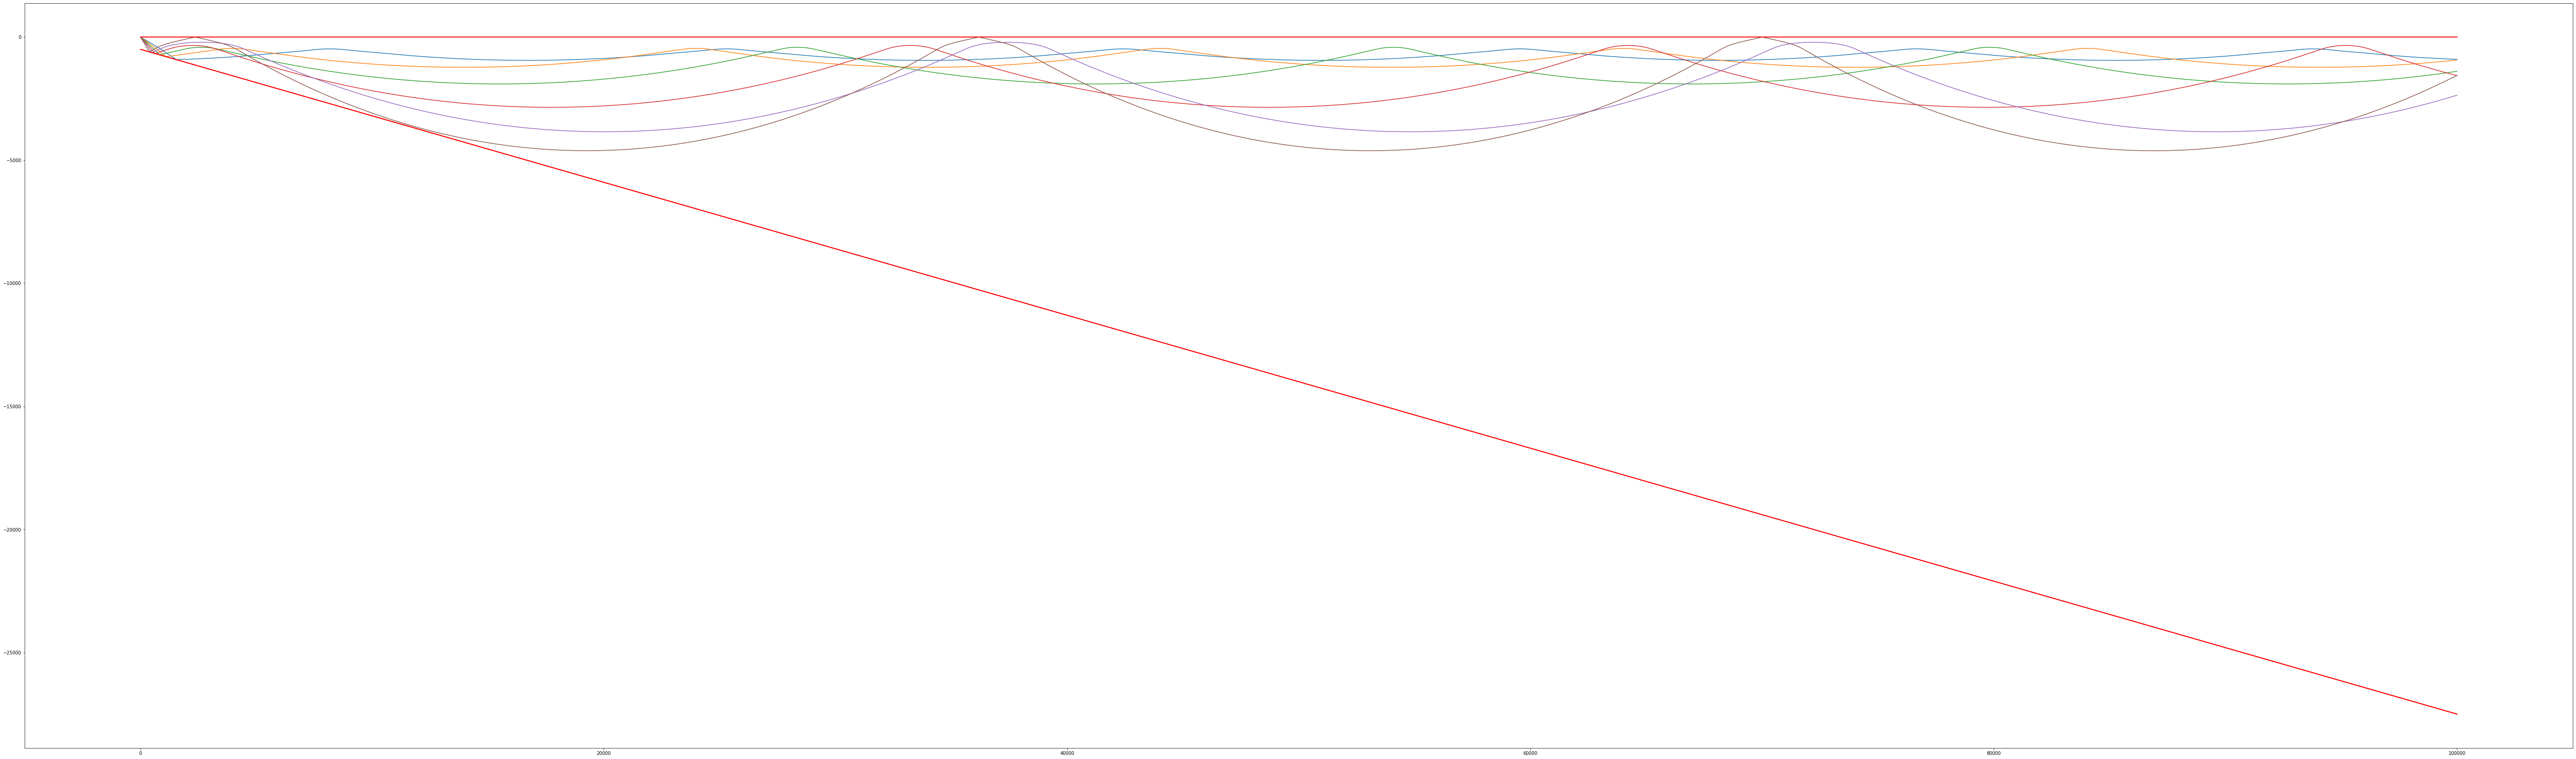

In [33]:
# plt.figure(figsize=(100, 4))
plt.figure(figsize=(100, 30))
for ray in sim.get_rays():
    plt.plot(ray.XZ[:,0], ray.XZ[:,1])
    plt.plot(ray.XZ[:,0], ceiling(ray.XZ[:,0]), c='red')
    plt.plot(ray.XZ[:,0], floor(ray.XZ[:,0]), c='red')
# plt.xlim((env.range_min.x, env.range_max.x))
# plt.ylim((env.range_min.z, env.range_max.z))
# plt.xlim((0, 50000))
# plt.ylim((-2000, 0))
plt.show()